Authors: Safia Shah , Adam Raabe  
Objective: Final Project  
Course: DATA 603, FA23  
Due: 11/30/23 by 11:59pm  

##**Description:**
- In this project, a dataset of about 81312 samples and 20 attributes is given regarding the reviews of various board games.
- Approach this project as a regression problem. **Average_rating** is your target variable. So your objective is to predict average rating as close as possible with the provided variables (you do not have to use all the variables).

- An important point is that for some games no user reviews were obtained (users_rated=0). Please discard those data points and work on the samples which has user rating. You may also find it comfortable to remove any rows with missing values.

- There are no specific instructions about which models you are going to use. You are expected to try several methods we have seen in the lectures (not only Linear Regression but also Support Vector Reg., Regression Trees etc.) and compare them. Also, you are supposed to apply best practices we have seen such as hyperparameter selection, cross validation and regularization.

#### A Note on Features
- bayes_average_rating regularizes the average rating in respect to the number of people that have reviewed it. It is essentially equivalent to the average rating and has the heaviest weight in determining the accuracy fo the model. Without this feature the accuracy drops significantly. **The 'dirty' dataset includes this column while the clean dataset does not.**
- bayes_average_rating was left in the dirtym model specifically due to our interpretation of Professor Yalin's email (11/20/23 note)

#### Semantics

- 'Dirty' in this case means that we did minimal cleaning on the data - just enough that the models would compile without errors. This includes removing rows with null values and rows where no users gave a rating.
- 'Clean' in this case means that we followed the same process we did for cleaning the dirty data, as well as additional steps with assumed added value: ignoring the bayes_average_rating column since it is calculated *only after we know our target variable*, dropping column values when those values were inconsistent with the variable being described, and removing zeroes that seemed to be default values rather than actual information.

#### A Note on Formatting.
- The intended viewing experience for this project is in Google Colab.  Under its interpreter, the notebook looks as expected, and notes and headings are not guaranteed to look sensible in other IDEs.  If you are using Jupyter to view this, please be aware that it may look a bit strange!

Implemented below are the following:
- Linear Regression
  - Polynomial Regression - attempted
- Decision Trees
  - Random Foresting
- SVR
- Ensembling
  - Majority voting
  - Bagging



# Data Preparation and exploration

In [1]:
# Libraries
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

>> **NOTE:**  Following lines load the data (Provided with project description)

In [2]:
!git clone https://github.com/cvrg-iyte/DATA602repo.git
import pandas
games = pandas.read_csv("./DATA602repo/games.csv.txt")

Cloning into 'DATA602repo'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 74 (delta 8), reused 0 (delta 0), pack-reused 54
Receiving objects: 100% (74/74), 7.96 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
print("Rows and Cols in DataFrame: ", games.shape,'\n')
games.info()

Rows and Cols in DataFrame:  (81312, 20) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81312 entries, 0 to 81311
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    81312 non-null  int64  
 1   type                  81312 non-null  object 
 2   name                  81271 non-null  object 
 3   yearpublished         81309 non-null  float64
 4   minplayers            81309 non-null  float64
 5   maxplayers            81309 non-null  float64
 6   playingtime           81309 non-null  float64
 7   minplaytime           81309 non-null  float64
 8   maxplaytime           81309 non-null  float64
 9   minage                81309 non-null  float64
 10  users_rated           81312 non-null  int64  
 11  average_rating        81312 non-null  float64
 12  bayes_average_rating  81312 non-null  float64
 13  total_owners          81312 non-null  int64  
 14  total_traders         81312

---
>> **NOTE:**  We orginally noticed that rows where specifically name == NaN still had some valuable information for average ratings and wanted to drop only null values in columns other than the name column. We later saw that throughout our data cleanup, all except for one NaN-named row was dropped anyway, so we simplified our code to just drop all NaNs.

In [3]:
# Dropping rows where null-values are present
games.dropna(axis=0, how='any', inplace=True)
print("Rows and Cols in DataFrame updated: ", games.shape,'\n')
games.info()

Rows and Cols in DataFrame updated:  (81268, 20) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81268 entries, 0 to 81311
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    81268 non-null  int64  
 1   type                  81268 non-null  object 
 2   name                  81268 non-null  object 
 3   yearpublished         81268 non-null  float64
 4   minplayers            81268 non-null  float64
 5   maxplayers            81268 non-null  float64
 6   playingtime           81268 non-null  float64
 7   minplaytime           81268 non-null  float64
 8   maxplaytime           81268 non-null  float64
 9   minage                81268 non-null  float64
 10  users_rated           81268 non-null  int64  
 11  average_rating        81268 non-null  float64
 12  bayes_average_rating  81268 non-null  float64
 13  total_owners          81268 non-null  int64  
 14  total_traders      

---
>> **NOTE:**  We observed a small sampling of the data to identify its makeup, as well as understand our target variable: "average_rating."

In [ ]:
## Exploration of the dataset
display(games.head(5))
print("Min Rating: " , games.query('users_rated > 0')['average_rating'].min())
print("Max rating: " , games.query('users_rated > 0')['average_rating'].max())

# the following basically provides general stats on the db including the min and max for all the columns
# games.describe()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


Min Rating:  1.0
Max rating:  10.0


---
>> **NOTE:**  The following code allowed us to notice *overtly incorrect* data:
- There was a long line of 0s in "bayes_average_rating," a feature which should never result in 0
- There was an over-represetation of 0s in the "year published" column.
- There was a string of 0 "average weight" scores, with no continuous data leading up to it, indicting it as a score that is either false or inconsistent with the scoring schema.
- 'average_rating' has a collection of points at 0, which, again, seems incorrect since it doesn't have continuous representation *up until* 0.  Also, a 0 rating is not incorporated into many scoring paradigms.
- There *ARE* obvious outlier points, such as "minplaytime" being 60k minutes long (after research, that is indeed incorrect for this game), but **outliers were not removed from the data.**

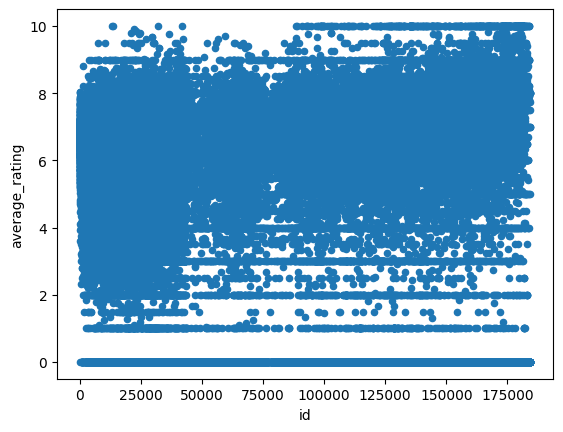

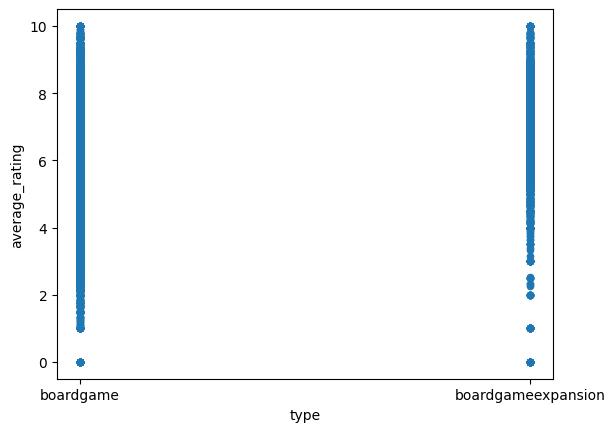

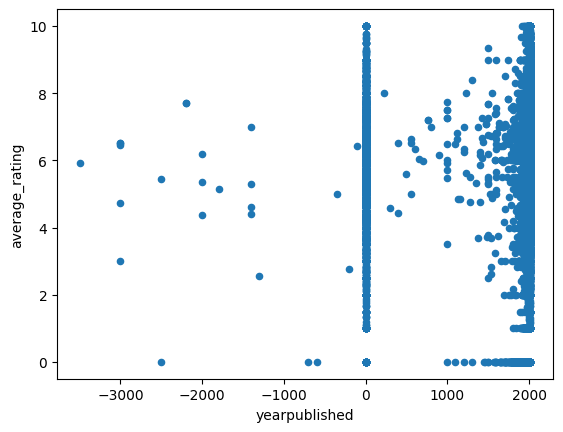

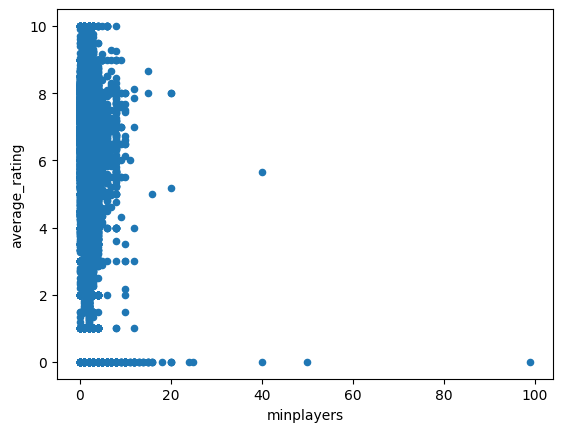

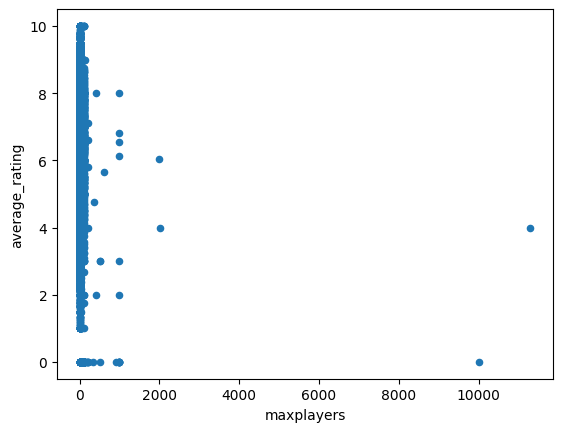

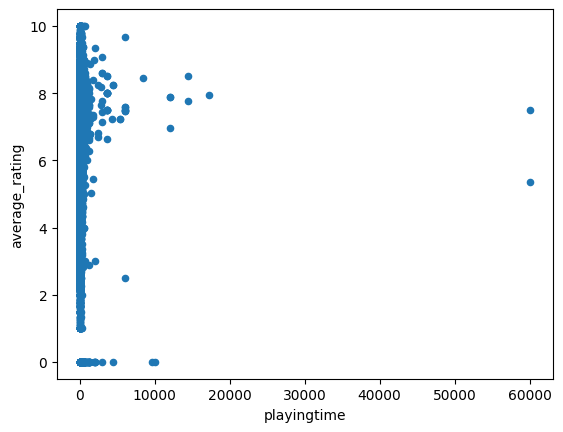

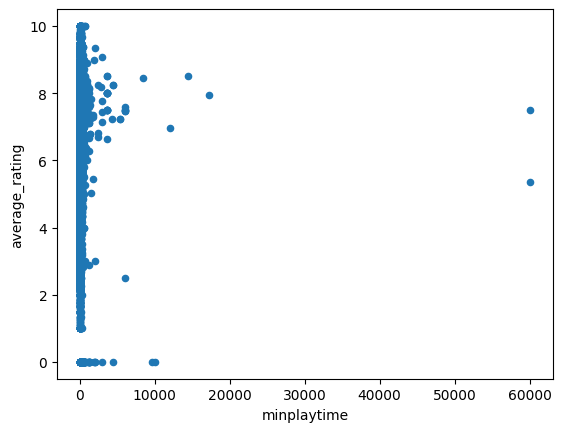

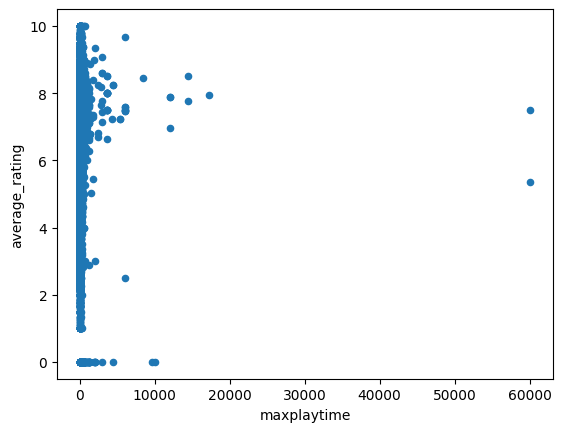

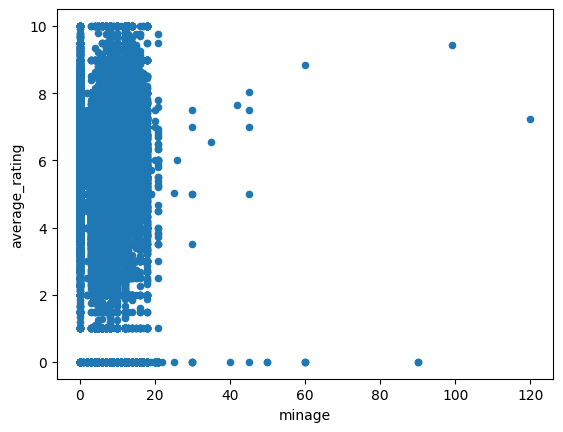

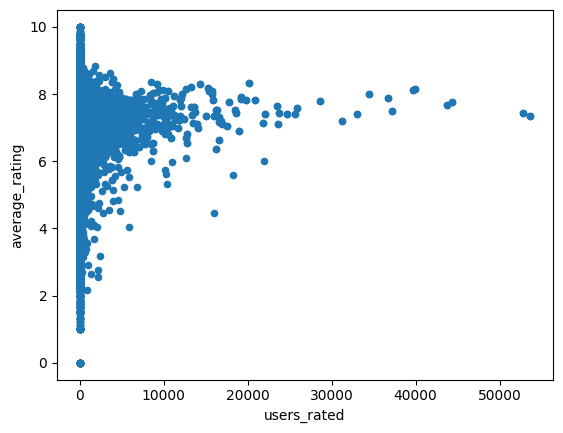

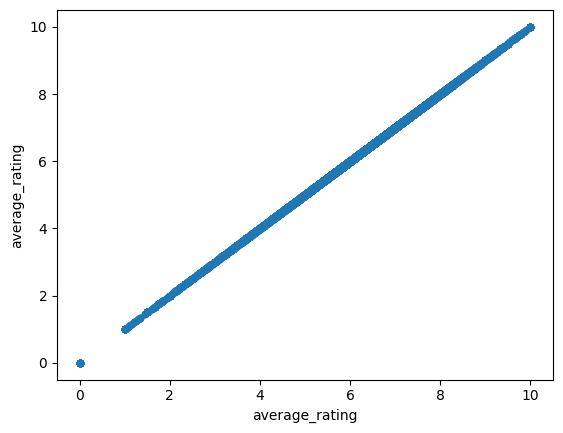

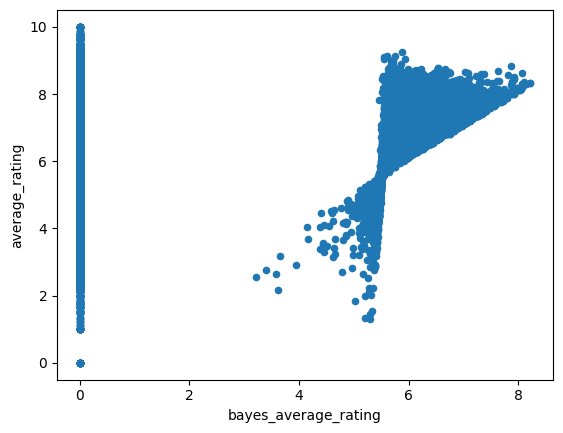

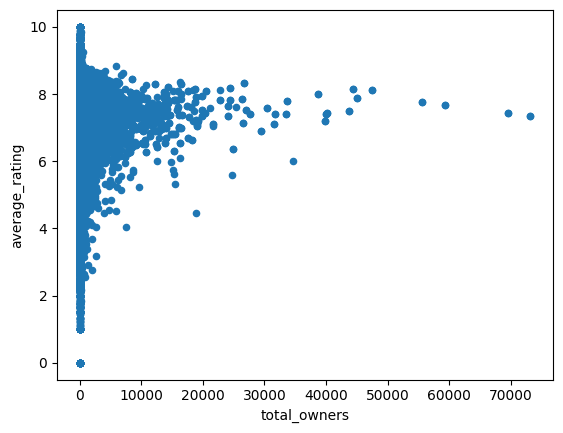

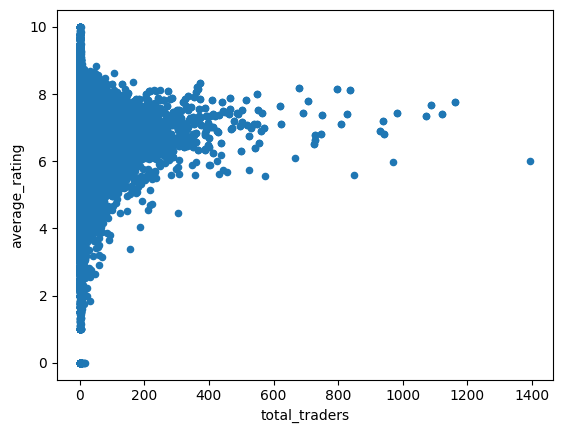

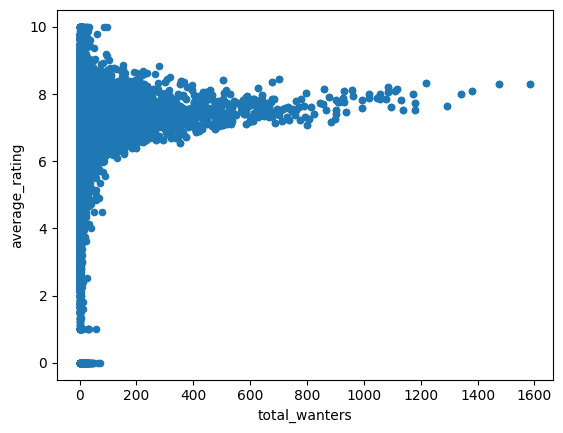

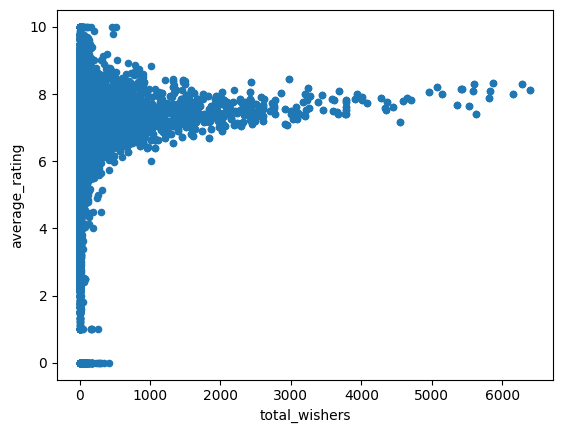

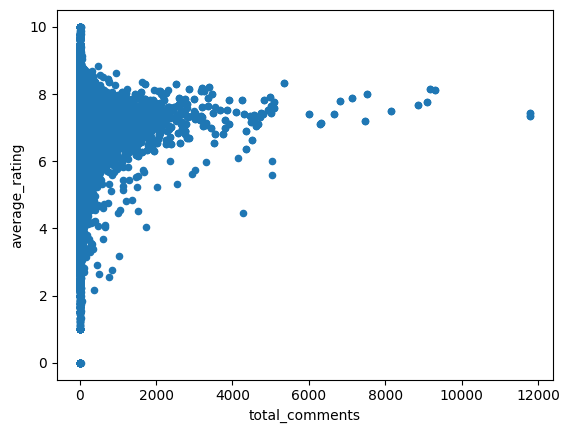

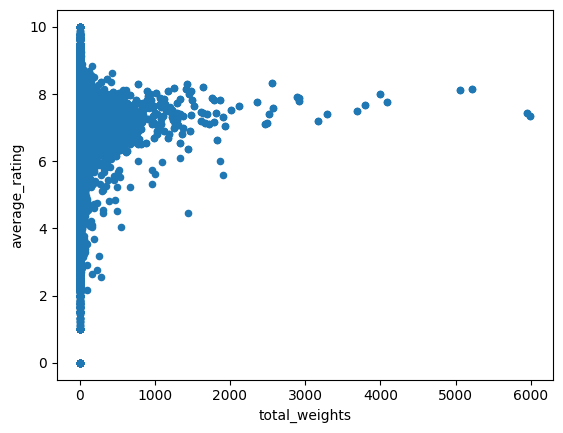

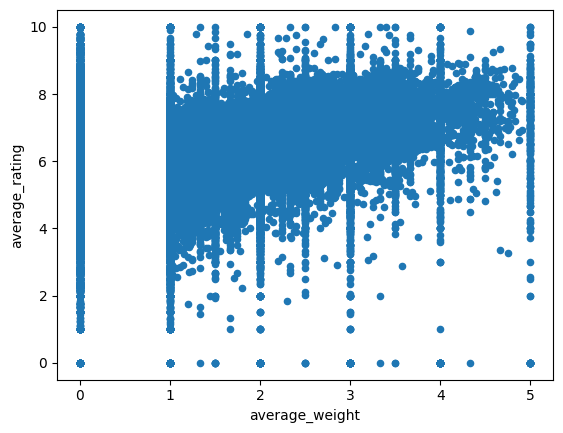

In [ ]:
colsNoName = games.columns.tolist()
colsNoName.remove('name')

for col in colsNoName:
    games.plot.scatter(x=col,y='average_rating')


---
>> **NOTE:**  The following code transforms the two-class varible "type" into integers to allow for specific regression methods to receive this column as an input.  Here we also split our data into **clean** and **dirty** models, to stay consistent with both the "Garbage In, Garbage Out" philosophy, as well as the professor's request, respectively.
- Our data also contained a sigificant portion of duplicate rows, which we removed by our "drop_duplicate" declaration of cleanData, since the game's ID should be unique.
- Our clean data has dropped from 81k rows to 14k rows.
- Our dirty data has dropped from 81k rows to 57k rows (because of the removal of null values).

In [4]:
# @title Label Encoding
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
labels.fit(['boardgame','boardgameexpansion'])


#dirtyData = games.query('users_rated != 0') # -> this will set a copy warning bc its a returned query, not an actual copy of the data
dirtyData = games.copy().loc[games["users_rated"] != 0] #-> this makes a copy of the orig df, then only returns where user_rated != 0
cleanData = games.copy().drop_duplicates(['id']).query('users_rated != 0 & bayes_average_rating != 0 & average_weight != 0 & yearpublished != 0')
print("Dirty data shape: " , dirtyData.shape, "\n")
print("Clean data shape: " , cleanData.shape, "\n")

## Converts the type category to a variable that can be put into our models
dirtyData['type'] = labels.transform(dirtyData['type'])
cleanData['type'] = labels.transform(cleanData['type'])


Dirty data shape:  (56894, 20) 

Clean data shape:  (14075, 20) 



In [ ]:
print("Numbers of zeros / nulls present in our clean data:")
for x in (cleanData.columns):
  print(str(x).ljust(25), str(len(cleanData.query( str(x) + " == 0"))).ljust(10), len(cleanData.query( str(x) + ".isnull()")))

Numbers of zeros / nulls present in our clean data:
id                        0          0
type                      11205      0
name                      0          0
yearpublished             0          0
minplayers                132        0
maxplayers                239        0
playingtime               756        0
minplaytime               739        0
maxplaytime               756        0
minage                    1206       0
users_rated               0          0
average_rating            0          0
bayes_average_rating      0          0
total_owners              0          0
total_traders             409        0
total_wanters             826        0
total_wishers             127        0
total_comments            0          0
total_weights             0          0
average_weight            0          0


In [ ]:
print("Numbers of zeros / nulls present in our dirty data:")
for x in (dirtyData.columns):
  print(str(x).ljust(25), str(len(dirtyData.query( str(x) + " == 0"))).ljust(10), len(dirtyData.query( str(x) + ".isnull()")))

Numbers of zeros / nulls present in our dirty data:
id                        0          0
type                      48039      0
name                      0          0
yearpublished             3476       0
minplayers                1240       0
maxplayers                3173       0
playingtime               9704       0
minplaytime               9448       0
maxplaytime               9704       0
minage                    12381      0
users_rated               0          0
average_rating            0          0
bayes_average_rating      40798      0
total_owners              1209       0
total_traders             24842      0
total_wanters             24501      0
total_wishers             15332      0
total_comments            8686       0
total_weights             21504      0
average_weight            21504      0


---
>> **NOTE:**  Here we created scaled versions of our data to see what benefits it might bring to our models.

In [5]:
# @title Scaling the Datasets
from sklearn.preprocessing import StandardScaler

#help(StandardScaler)

# Scale our dirty data
dirtyScaler = StandardScaler()
dirtyScaler.fit(dirtyData.drop(['id','name'], axis = 1))

scaledData = dirtyScaler.transform(dirtyData.drop(['id','name'],axis = 1))
scaledDF = pandas.DataFrame(scaledData,columns = dirtyData.drop(['id','name'],axis =1 ).columns)

scaledDirtyData = (pandas.concat([dirtyData[['id','name']].reset_index(),scaledDF], axis = 'columns').drop(['index'],axis = 1))
display(scaledDirtyData.describe())
print('\n')

## Scale our clean data
cleanScaler = StandardScaler()
cleanScaler.fit(cleanData.drop(['id','name'], axis = 1))

scaledData = cleanScaler.transform(cleanData.drop(['id','name'],axis = 1))
scaledDF = pandas.DataFrame(scaledData,columns = cleanData.drop(['id','name'],axis =1 ).columns)

scaledCleanData = (pandas.concat([cleanData[['id','name']].reset_index(),scaledDF], axis = 'columns').drop(['index'],axis = 1))
display(scaledCleanData.describe())

,id,type,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
count,56894.000000,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04,5.689400e+04
mean,64092.223943,6.394310e-17,2.058169e-16,1.119004e-16,6.993777e-18,6.743999e-18,-1.099022e-17,6.743999e-18,-1.598578e-17,-7.992888e-18,-1.278862e-16,-1.039075e-16,3.996444e-18,3.197155e-17,-3.996444e-17,-5.994666e-18,-1.198933e-17,-7.992888e-18,5.195377e-17
std,57513.253779,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,1.000000,-4.293360e-01,-1.105861e+01,-2.533056e+00,-1.097600e-01,-1.474271e-01,-1.461294e-01,-1.474271e-01,-1.559004e+00,-1.688721e-01,-3.177136e+00,-6.251354e-01,-2.095747e-01,-2.802305e-01,-2.500940e-01,-2.131871e-01,-2.078898e-01,-1.705789e-01,-1.046041e+00
25%,16133.250000,-4.293360e-01,2.349802e-01,-6.107066e-03,-7.036891e-02,-1.105220e-01,-1.079802e-01,-1.105220e-01,-7.375632e-01,-1.681390e-01,-6.435917e-01,-6.251354e-01,-2.067767e-01,-2.802305e-01,-2.500940e-01,-2.131871e-01,-2.049345e-01,-1.705789e-01,-1.046041e+00
50%,36921.000000,-4.293360e-01,2.679001e-01,-6.107066e-03,-3.097786e-02,-7.361699e-02,-6.983114e-02,-7.361699e-02,8.387815e-02,-1.644736e-01,8.480225e-02,-6.251354e-01,-1.983827e-01,-2.589468e-01,-2.362020e-01,-2.026297e-01,-1.960685e-01,-1.633352e-01,-2.222028e-01
75%,118558.750000,-4.293360e-01,2.802451e-01,-6.107066e-03,8.413197e-03,1.931287e-04,6.467079e-03,1.931287e-04,9.053194e-01,-1.410151e-01,6.485158e-01,1.448699e+00,-1.396246e-01,-1.525283e-01,-1.667418e-01,-1.603998e-01,-1.517387e-01,-1.343606e-01,6.016357e-01
max,184260.000000,2.329178e+00,2.925901e-01,4.800591e+01,2.224300e+02,1.477680e+02,1.527555e+02,1.477680e+02,2.308423e+01,3.918199e+01,2.523338e+00,2.481648e+00,4.074649e+01,2.941054e+01,2.178268e+01,2.231646e+01,3.465900e+01,4.326240e+01,3.073151e+00


,id,type,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
count,14075.000000,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04,14075.000000,1.407500e+04,14075.000000,1.407500e+04,1.407500e+04,1.407500e+04,1.407500e+04
mean,51985.163339,6.461774e-17,3.695327e-16,-1.817374e-17,4.644400e-17,6.057913e-18,2.019304e-18,6.057913e-18,1.938532e-16,-8.077218e-18,-6.784863e-16,-2.100077e-16,0.000000,3.230887e-17,0.000000,3.230887e-17,-3.230887e-17,-1.615444e-17,9.692661e-17
std,55479.072177,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036,1.000036e+00,1.000036,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,1.000000,-5.060985e-01,-4.777285e+01,-3.014464e+00,-3.740147e-01,-1.515773e-01,-1.482478e-01,-1.515773e-01,-2.427797e+00,-2.706732e-01,-5.428478e+00,-6.051994e+00,-0.374475,-5.237457e-01,-0.426040,-3.514870e-01,-3.579004e-01,-2.824647e-01,-1.437351e+00
25%,6020.500000,-5.060985e-01,-7.691828e-03,-7.007948e-02,-2.342031e-01,-9.872985e-02,-9.421630e-02,-9.872985e-02,-3.860010e-01,-2.587907e-01,-6.448965e-01,-5.625910e-01,-0.316969,-4.331836e-01,-0.385777,-3.236264e-01,-3.096455e-01,-2.568325e-01,-8.227470e-01
50%,25754.000000,-5.060985e-01,7.921713e-02,-7.007948e-02,-9.439146e-02,-7.230611e-02,-6.720057e-02,-7.230611e-02,1.244480e-01,-2.298596e-01,3.520814e-02,-3.685007e-01,-0.253595,-3.124342e-01,-0.305250,-2.729709e-01,-2.613906e-01,-2.209476e-01,-1.203779e-01
75%,99080.000000,-5.060985e-01,1.226716e-01,-7.007948e-02,4.542015e-02,6.965103e-03,1.384665e-02,6.965103e-03,6.348970e-01,-1.198180e-01,7.143533e-01,1.724744e-01,-0.073252,4.532928e-03,-0.063670,-1.007421e-01,-1.040377e-01,-1.081663e-01,6.523019e-01
max,183880.000000,1.975900e+00,1.661261e-01,1.170746e+01,6.946188e+01,1.055434e+02,1.079147e+02,1.055434e+02,2.819914e+01,2.744639e+01,2.910549e+00,5.845031e+00,28.256157,2.053193e+01,15.538354,1.586335e+01,2.439266e+01,3.045044e+01,3.479479e+00


<ipython-input-11-2edb4aec9635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scaledDirtyData['average_rating'])


<Axes: xlabel='average_rating', ylabel='Density'>

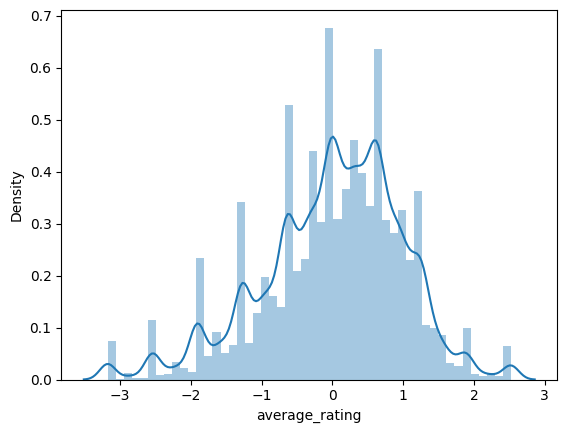

In [ ]:
sns.distplot(scaledDirtyData['average_rating'])

<ipython-input-12-5654fa1a2a41>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scaledCleanData['average_rating'])


<Axes: xlabel='average_rating', ylabel='Density'>

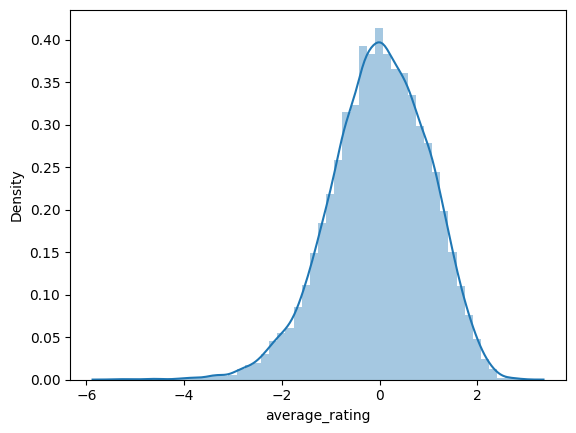

In [ ]:
sns.distplot(scaledCleanData['average_rating'])

>> **NOTE:**  We can see the benefits of cleaning our data based on the density functions for our "average_rating" variable. We go from having sharp peaks at what are presumably originally whole numbers to a smooth, almost-normal distribution.
---

##Splitting the Dataset
- Using train_test_split, we randomly split the dataset into training and testing sets.
- We performed our models on both a cleaner version of the dataset and a "dirty" version that just removed average_rating = 0 and null values.



- We have intentionally left out "bayes_average_rating" because it is calculated using our average_rating, meaning that in order to use it as a predictor for average_rating, average_rating **would already need to be known**, and at that point, what's the point of modelling it?
- In the end, we included "bayes_average_rating" in our dirty models because we felt it followed the actual spirit of our original instructions.

In [6]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


## I.E. "Given the details of a game, what would we hope that the game scores before seeing any public opinion?"
userless_columns = ['type','yearpublished','minplayers','maxplayers','playingtime','minplaytime','maxplaytime',
           'minage','average_weight']



## All seemingly fair columns to pull data from -> maybe not "average_weight"? but details of the columns were not given to us
columns = ['type','yearpublished','minplayers','maxplayers','playingtime','minplaytime','maxplaytime',
           'minage','users_rated','total_owners','total_traders','total_wanters','total_wishers',
           'total_comments','total_weights','average_weight']
# This leaves out 'id', 'name', 'average_rating', and 'bayes_average_rating'


cleantarget = scaledCleanData['average_rating']
dirtytarget = scaledDirtyData['average_rating']
# xtrain xtest ytrain ytest -> order of return values for train test split
cleanX, cleanTestX, cleany, cleanTesty = train_test_split(scaledCleanData[columns],cleantarget, train_size=0.7, test_size=0.3)
# added bayes average to 'dirty' dataset
dirtyX, dirtyTestX, dirtyy, dirtyTesty = train_test_split(scaledDirtyData[columns+['bayes_average_rating']],dirtytarget, train_size=0.7, test_size=0.3)


# Model 1: Linear Regression

- For quick reference, our dirty data achieved a score of 23%, and our clean data achieved a score of 47%.

- After RFE, we trimmed our dirty data model to 4 features with an accuracy of 22% and our clean data model to 5 features with an accuracy of 48% <= Small increase due to variability in the LinearRegression() results

---
>> **NOTE:**  We started by looking at the linear correlations for each variable with average_rating.  Essentially this either helps justify or rule out the use of Linear Regression, depending on how sigificant the correlations are.  We found *essentially* no significant correlations, indicating that Linear Regression probably isn't a well-suited model for achieving high accuracy.
- Top 4 correlations for dirty data: average_weight, type, total_wanters, and total_wishers
- Top 4 correlations for clean data: average_weight, type, minage, and total_wanters

In [ ]:
# Correlations between the different columns and average_rating
scaledDirtyData.corr(numeric_only = True)['average_rating'].sort_values(axis = 0,ascending = False,key = lambda x: abs(x))

average_rating          1.000000
average_weight          0.351081
type                    0.331864
id                      0.304201
bayes_average_rating    0.231563
minage                  0.210049
total_wanters           0.196566
total_wishers           0.171375
total_owners            0.137478
total_comments          0.123714
total_traders           0.119452
users_rated             0.112564
total_weights           0.109691
yearpublished           0.108461
playingtime             0.048994
maxplaytime             0.048994
minplaytime             0.043985
minplayers             -0.032701
maxplayers             -0.008335
Name: average_rating, dtype: float64

In [ ]:
# Perform individual LinearRegressions for clean and dirty, and report results
dirtyLR = LinearRegression()
dirtyLR.fit(dirtyX,dirtyy) ## Throws an error with any NaN values
print(dirtyLR.coef_, '\n')
print("Accuracy for our 'Dirty' model as is:", dirtyLR.score(dirtyTestX,dirtyTesty), '\n')

cleanLR = LinearRegression()
cleanLR.fit(cleanX,cleany)
print(cleanLR.coef_ , '\n')
print("Accuracy for our 'Clean' model as is:", cleanLR.score(cleanTestX,cleanTesty), '\n')

[ 0.28408607  0.03432299 -0.01996953 -0.01221046  0.02676043 -0.04289833
  0.02676043  0.09099396 -0.2390305   0.11510406 -0.06211715  0.08376481
  0.03551249  0.1795262  -0.01748052  0.24869725  0.02101781] 

Accuracy for our 'Dirty' model as is: 0.22822006269341732 

[ 3.07874346e-01  6.68258634e-02 -4.95964685e-04  6.58823514e-03
  1.52387809e-02 -3.98865949e-02  1.52387809e-02  2.35790683e-03
 -5.52570375e-01  4.46359585e-01 -1.66265601e-01  3.67032200e-01
 -1.05723884e-01  2.39242874e-01  1.36789589e-02  3.88976080e-01] 

Accuracy for our 'Clean' model as is: 0.47230439383727085 



---
>> **NOTE:**  After our initial results for Linear Regression, we used RFE to determine how few columns of data we could use to achieve nearly identical results.
- RFE indicated that significant accuracy drops began around **4 features for the dirty data**
- RFE indicated that significant accuracy drops began around **5 features for the clean data**

In [ ]:
#@title RFE Analysis

fig = make_subplots(cols = 2,shared_yaxes=True)
ctr = 0

for job in [['Dirty',dirtyX,dirtyy],['Clean',cleanX,cleany]]:
  ks = [ i for i in range(1,job[1].shape[1])]
  accuracy = []
  for k in ks:
    model = Pipeline([
        ("RFE",RFE(LinearRegression(),n_features_to_select=k)),
        ("LR",LinearRegression())
    ])

    accuracy.append(cross_val_score(model, job[1],job[2], cv=5).mean())

  fig.add_trace(go.Scatter(x = ks,y = accuracy),row = 1, col = ctr + 1)
  fig.update_xaxes(title_text = (job[0] + " 'K's"), col = ctr + 1)

  ctr +=1

fig.show()

## It looks like we can eliminate down to 5 features and still be as efficient with this model, since in our clean data,
## we have no increase past that point, and in the dirty data we see no increase past 4 or so

---
>> **NOTE:**  Given the results from the cell above, we ran our LinearRegression models with 4 and 5 features for dirty and clean models, respectively.

>> **ADDITIONAL NOTE:** It is comforting to see that the features selected by RFE were the same ones that we saw earlier as having the highest correlations with our target variable.

In [ ]:
Dirty_RFE = RFE(LinearRegression(),n_features_to_select=4)
Clean_RFE = RFE(LinearRegression(),n_features_to_select=5)

Dirty_RFE.fit(dirtyX,dirtyy)
print("Dirty data score after RFE: " ,Dirty_RFE.score(dirtyTestX,dirtyTesty))
print(Dirty_RFE.get_feature_names_out(), "\n")

Clean_RFE.fit(cleanX,cleany)
print("Dirty data score after RFE: " ,Clean_RFE.score(cleanTestX,cleanTesty))
print(Clean_RFE.get_feature_names_out(), "\n")

Dirty data score after RFE:  0.20379470329380878
['type' 'playingtime' 'maxplaytime' 'average_weight'] 

Dirty data score after RFE:  0.4645526280250678
['type' 'users_rated' 'total_owners' 'total_wanters' 'average_weight'] 



---
>> **NOTE:**  Does using a different Linear Regression method provide better results?
- The short answer is no.

In [ ]:
# @title Linear Regression using Ridge Regression
from sklearn.linear_model import Ridge

fig = make_subplots(cols = 2,shared_yaxes=True)
ctr = 0

for job in [['Dirty',dirtyX,dirtyy],['Clean',cleanX,cleany]]:
  alphas = [ .01, .05, .1, .5, 1, 5, 10 ,50 ]
  accuracy = []
  for alpha in alphas:
    model = Pipeline([
        ("RFE",RFE(Ridge(alpha),n_features_to_select=5)),
        ("LR",Ridge(alpha))
    ])

    accuracy.append(cross_val_score(model, job[1],job[2], cv=5).mean())

  fig.add_trace(go.Scatter(x = alphas,y = accuracy),row = 1, col = ctr + 1)
  fig.update_xaxes(title_text = (job[0] + " alphas"), col = ctr + 1)

  ctr +=1

fig.show()


## Basically all this shows is that the alphas don't sigificantly change our models' results regardless of the alpha, or using Ridge()

---
>> **NOTE:**  What insights can we get from *parameterizing* our variables?  Can we keep our accuracy "high" with fewer *parameterized* variables?

In [ ]:
# @title PCA Analysis
from sklearn.decomposition import PCA

fig = make_subplots(cols = 2,shared_yaxes=True)
ctr = 0

for job in [['Dirty',dirtyX,dirtyy],['Clean',cleanX,cleany]]:
  ks = [ i for i in range(1,job[1].shape[1])]
  accuracy = []
  for k in ks:
    model = Pipeline([
        ("PCA",PCA(n_components=k)),
        ("LR",LinearRegression())
    ])

    accuracy.append(cross_val_score(model, job[1],job[2], cv=5).mean())

  fig.add_trace(go.Scatter(x = ks,y = accuracy),row = 1, col = ctr + 1)
  fig.update_xaxes(title_text = (job[0] + " 'K's"), col = ctr + 1)

  ctr +=1

fig.show()

## Our PCA analysis seems to indicate that we could get away with 7 features for our clean data, and maybe 5 or 7 for our dirty data.
## From what I understand, this means that our RFE analysis lead to a simpler model, since we can be confident with 5 features.

Sum of eigenvalues: 17.20658880012772 



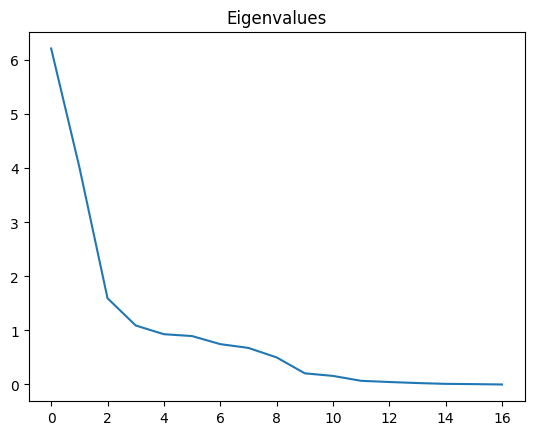

In [ ]:
cov_mat = np.cov(dirtyX.T)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
tot = sum(eigen_vals)
print('Sum of eigenvalues:', tot, '\n')

plt.plot(eigen_vals)
plt.title('Eigenvalues', loc='center')
plt.show()

## We have weird behavior up until 8 or 9 components, this time for *both* our dirty data and our clean data.
## The crux of either elbow is unclear.

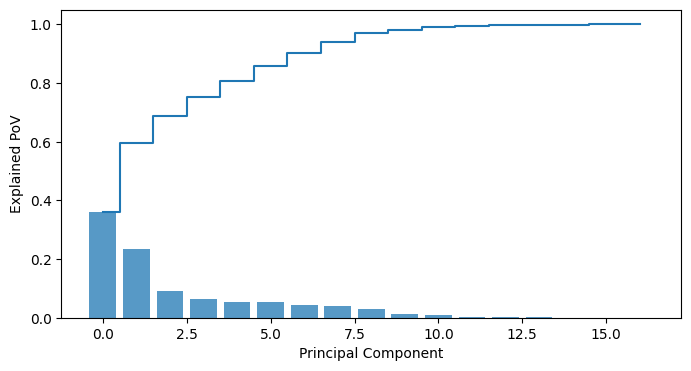

In [ ]:
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

xvalues = np.linspace(0, len(var_exp) - 1 , len(var_exp))
plt.figure(figsize=(8,4))
plt.bar(xvalues, var_exp, alpha=0.75, align='center')
plt.step(xvalues, cum_var_exp, where='mid')
plt.xlabel('Principal Component')
plt.ylabel('Explained PoV') # Percentage of Variation
plt.show()

---
>> **NOTE:**  We can visualize most of our components for our dirty data PCA results.  With our clean data requiring 7 components to achieve decent scores, this becomes much less convenient to do.  Since no real information other than the visualization being rather normal looking and still difficult to observe much complexity within due to outliers, no effort was made to copy the results to the clean data model.

In [ ]:
X_projected = PCA(5).fit_transform(dirtyX)

print(X_projected)
x_min, x_max = np.min(X_projected, 0), np.max(X_projected, 0)
X_projected = (X_projected - x_min) / (x_max - x_min)
print('\n', X_projected)

[[-0.03364715  0.06841548 -0.77804641 -0.27987135 -1.0944303 ]
 [ 0.31760641 -0.03708927 -1.48898349  0.52793944 -0.58818567]
 [-0.6624476  -0.13272854  0.51949143  0.09625109  0.22990933]
 ...
 [-0.70623498  0.15828806 -0.44840616 -0.73125903  1.73780729]
 [-0.688829   -0.00201064  0.37892575  0.49650381  0.61359729]
 [-0.77906931 -0.16335639  0.85912173  0.21351876  0.55340578]]

 [[0.0142403  0.01925214 0.374784   0.08719999 0.38572511]
 [0.01891384 0.01885061 0.35262609 0.10517271 0.41143385]
 [0.00587391 0.01848663 0.4152246  0.09556822 0.45297935]
 ...
 [0.00529131 0.01959417 0.38505796 0.07715721 0.52955528]
 [0.0055229  0.01898411 0.41084357 0.10447331 0.47246426]
 [0.00432223 0.01837007 0.42580992 0.09817727 0.46940755]]


>> **NOTE:** Below is commented out due to it taking a lot of resources to keep active.  However, it can help to visualize the dimensions to which PCA has reduced the dirty data model.

In [ ]:
## This allows us to visualize our data in terms of our 4 most relevant dimensions, the 4th being gained via color.
#import plotly.express as px
#px.scatter_3d(X_projected, x = 0, y = 1, z = 2,template="plotly_dark",color= 3)

In [ ]:
## Store our models
dirty_X_PCA_5 = PCA(5).fit(dirtyX)
dirty_X_PCA_7 = PCA(7).fit(dirtyX)
clean_X_PCA = PCA(7).fit(cleanX)

## Transform our data to LinearRegress upon
dirty_X_projected_5 = pandas.DataFrame(dirty_X_PCA_5.transform(dirtyX))
dirty_X_projected_7 = pandas.DataFrame(dirty_X_PCA_7.transform(dirtyX))
clean_X_projected = pandas.DataFrame(clean_X_PCA.transform(cleanX))

## Run our Regression and retrieve our scores
LR_projected_dirty_5 = LinearRegression().fit(dirty_X_projected_5,dirtyy)
LR_projected_dirty_7 = LinearRegression().fit(dirty_X_projected_7,dirtyy)
print("Dirty Data score under 5 primary components: ",LR_projected_dirty_5.score(dirty_X_PCA_5.transform(dirtyTestX),dirtyTesty))
print("Dirty Data score under 7 primary components: ",LR_projected_dirty_7.score(dirty_X_PCA_7.transform(dirtyTestX),dirtyTesty),"\n")

LR_projected_clean = LinearRegression().fit(clean_X_projected,cleany)
print("Clean Data score under 7 primary components: ",LR_projected_clean.score(clean_X_PCA.transform(cleanTestX),cleanTesty))

Dirty Data score under 5 primary components:  0.187393764203046
Dirty Data score under 7 primary components:  0.21729141784553518 

Clean Data score under 7 primary components:  0.40251600174768165


>> **NOTE:**  For both models, it took **7 PCA components to achieve close to, but lower than results than our RFE scores**, with our dirty data needing only 4 RFE components to achieve close to its maximum score, and our clean data needing only 5 RFE components to achieve close its maximum score.  Therefore, **we'll stick with our RFE model as the primary "successful" model.**
---

## Sub-Model for Model 1: Polynomial Regression

Polynomializing our data dramatically increases our calculation time.  Models created this way end up being unfeasible for recalculation *very* quickly.  In one instance, I attempted to calculate a model that took over 3 hours to process.  Despite this, we were seeing **no appreciable increase in accuracy** over linear regression.  This does make sense, since exploration of the data has never particularly suggested any linear relations, and similar explorations of the polynomialized data also did not.  **All of this was true regardless of cleaning our data.**

- For quick reference, our dirty data achieved a score of 26% and our clean data achieved a score of 43%

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

polify = PolynomialFeatures(2)
polify.set_output(transform = 'pandas')
polify.fit(dirtyX)

polyData = polify.transform(dirtyX)
display(polyData)

,1,type,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,...,total_wishers^2,total_wishers total_comments,total_wishers total_weights,total_wishers average_weight,total_comments^2,total_comments total_weights,total_comments average_weight,total_weights^2,total_weights average_weight,average_weight^2
53731,1.0,-0.429336,0.286418,-0.006107,0.008413,-0.073617,-0.069831,-0.073617,0.905319,-0.163007,...,0.041059,0.039130,0.033097,-0.121909,0.037293,0.031542,-0.116184,0.026678,-0.098268,0.361966
40672,1.0,-0.429336,0.278188,-2.533056,-0.109760,-0.147427,-0.146129,-0.147427,-1.559004,-0.168872,...,0.045449,0.043689,0.036365,0.223003,0.041998,0.034957,0.214370,0.029097,0.178433,1.094203
25357,1.0,-0.429336,-3.857379,-0.006107,-0.070369,0.000193,0.006467,0.000193,0.083878,-0.168872,...,0.043961,0.041109,0.035765,0.219321,0.038443,0.033445,0.205096,0.029097,0.178433,1.094203
54656,1.0,2.329178,0.286418,-0.006107,-0.070369,0.221623,0.235362,0.221623,0.083878,-0.168139,...,0.045449,0.044319,0.036365,0.223003,0.043218,0.035462,0.217461,0.029097,0.178433,1.094203
48045,1.0,2.329178,0.282303,1.257367,-0.011282,-0.049014,-0.044398,-0.049014,0.494599,-0.165207,...,0.036892,0.039362,0.032763,0.200915,0.041998,0.034957,0.214370,0.029097,0.178433,1.094203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36104,1.0,-0.429336,0.010713,-0.006107,-0.070369,-0.098220,-0.095264,-0.098220,-0.121482,-0.168872,...,0.038256,0.040661,0.033364,0.204597,0.043218,0.035462,0.217461,0.029097,0.178433,1.094203
50227,1.0,2.329178,0.284360,-0.006107,-0.070369,-0.147427,-0.146129,-0.147427,-1.559004,-0.165940,...,0.043961,0.041729,0.035765,0.219321,0.039610,0.033949,0.208187,0.029097,0.178433,1.094203
2334,1.0,-0.429336,0.265843,-0.006107,0.008413,0.074003,0.082765,0.074003,0.494599,1.432169,...,1.626687,3.002808,2.951309,2.354160,5.543079,5.448013,4.345696,5.354577,4.271166,3.406965
3107,1.0,-0.429336,0.282303,-0.006107,-0.011282,0.000193,0.006467,0.000193,0.494599,0.608923,...,8.664177,1.875986,1.203637,3.013709,0.406192,0.260614,0.652535,0.167210,0.418668,1.048275


---
>> **NOTE:**  Our correlations are almost entirely insignificant for 2nd-Order Polynomials:
- For dirty data, we have 7 combinations that even break the .15 correlation coefficient, and only 3 that break .30, average_weight, type, and type^2, effectively meaning still only two features break .30 correlation
- For clean data, we have better results but still not great results, with 12 combos that break the .15 correlation coefficient and 4 that break the .30 coefficient

>> This does not bode well for having any great success with polynomial regression

>> **ADDITIONAL NOTE:** We see similar results for higher-order polynomials, but with much longer calculation times.

In [ ]:
tempstorage = polyData.copy()
tempstorage['1'] = dirtyy ## Replace the "bias" variable with our target variable

display(pandas.DataFrame(tempstorage.corr(numeric_only = True)['1'].sort_values(axis = 0,ascending = False,key = lambda x: abs(x))))

,1
1,1.000000
average_weight,0.355316
type,0.331589
type^2,0.331589
average_weight^2,0.217423
...,...
maxplayers playingtime,0.001031
maxplayers maxplaytime,0.001031
maxplayers total_traders,0.000910
minplaytime total_traders,0.000840


---
>> **NOTE:**  Apparently, this can vary wildly.  During some iterations of the notebook, the accuracy dipped into -84% ranges, with no explanation other than that it must have had an extremely strange selection of data selected to build and score the models. However, when our models performance peaked we saw accuracies like:
- For dirtyData, the max accuracy we saw was around 26% or so, so not much better than pure linear analysis
- For cleanData, the max accuracy we saw was around 43% or so, so  again, not much better than pure linear analysis

Accurcy:  -0.21537118563915425 

Sum of eigenvalues: (82481.48462391626+0j) 



/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning:

Casting complex values to real discards the imaginary part



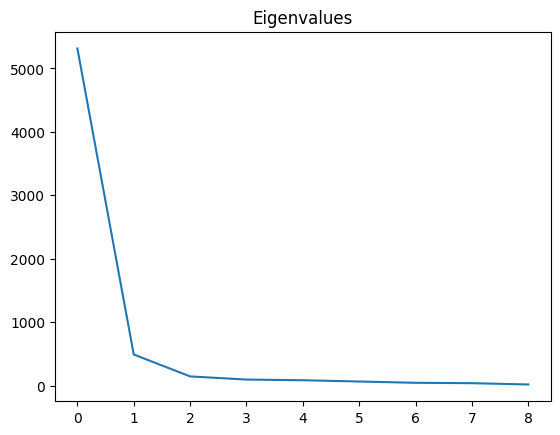

In [ ]:
# This is left as the dirty data version, but if you want to run clean data, you'll need to update the polify function earlier to be trained on clean data
PR = LinearRegression()
PR.fit(polyData,dirtyy)
print("Accurcy: ", PR.score(polify.transform(dirtyTestX),dirtyTesty), "\n")

cov_mat = np.cov(polyData.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
tot = sum(eigen_vals)
print('Sum of eigenvalues:', tot, '\n')

## Skipping the 0th index bc it's *far and away* larger than the rest and makes it hard to discern any elbow
plt.plot(eigen_vals[1:10])
plt.title('Eigenvalues', loc='center')
#plt.yscale("log")
plt.show()

---
>> **NOTE:** We used RFE to see if we can select only the best combinations of varibles to use our model.
- We saw that our model ran *WILDLY* negative through most iterations of possible ks.
- This helps us conclude that **polynomial regression is not likely to provide any significant increases in accuracy** to our predictions, meaning that we need to look to our other models instead.

>> **ADDITIONAL NOTE:**  This is commented out bc accidentally running it can stall the program. For 5th degree polynomials, it runs for upwards of 8 hours, at which point it died.

In [ ]:
#testPolify = PolynomialFeatures(3) ## 3 includes *all lower order polynomials as well*
#testPolify.set_output(transform = 'pandas')

#sourceX = cleanX
#sourcey = cleany

#data = testPolify.fit_transform(sourceX)

# This makes it run for a very long time bc our columns are upwards of 153, and each one needs to be fit data.shape[1] - ks number of times
#ks = [ 2, 3, 5, 20, 30, 50, 100, 150]
#accuracy = []
#for k in ks:
#  model = Pipeline([
#      ("RFE",RFE(LinearRegression(),n_features_to_select=k)),
#      ("LR",LinearRegression())
#  ])
#  ## Changed to cv = 3 just for computational purposes. It takes too long to do RFE on the hundreds or thousands of features added by PolynomialFeatures
#  accuracy.append(cross_val_score(model, data,sourcey, cv=3).mean())


#plt.plot(ks,accuracy)

# Model 2: Regression Tree
- For quick reference, our dirty data achieved a score of 37%, and our clean data achieved a score of 61%.

- We were able to boost that accuracy using Random Foresting.  With it, our dirty data achieved a score of 41%, and our clean data achieved a score of 72%.

## Sub-model for Model 2: Clean Data
- This submodel uses the "clean" data set.
- We determine the **optimum hyperparameter for "max_depth" to be 7** via cross-validation, achieving an **accuracy of 61%** on our testing data.

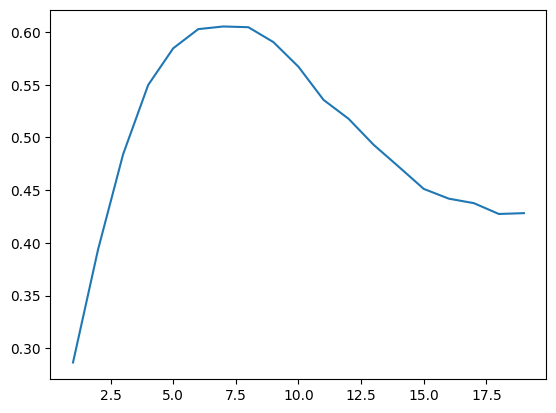

In [ ]:
sourceX = cleanX
sourcey = cleany
accuracy = []
depths = [x for x in range(1,20)]

for depth in depths:
  DT = DecisionTreeRegressor(max_depth = depth, min_samples_leaf = 1)
  accuracy.append(cross_val_score(DT, sourceX, sourcey, cv = 5).mean())


plt.plot(depths,accuracy)

In [ ]:
DT_clean = DecisionTreeRegressor(max_depth = 7)
DT_clean.fit(cleanX,cleany)
print(DT_clean.score(cleanTestX,cleanTesty))

0.6155822171309595


### Feature importances
- Below we can see both visually and numerically the comparison between feature importances.  We found that:
 - "total_wanters" had a feature weight of .488
 - "average_weight" had a feature weight of .206
 - "type" had a feature weight of .111
 - "yearpublished" had a feature weight of .061
 - "total_traders" had a feature weight of .048

In [ ]:
# feature importances with their respective name
for i in range(len(DT_clean.feature_names_in_)):
  print(DT_clean.feature_names_in_[i],DT_clean.feature_importances_[i])

type 0.13064143568853273
yearpublished 0.07090259237821928
minplayers 0.0
maxplayers 0.0069926606214467234
playingtime 0.00038142650079450616
minplaytime 0.0003152553173132624
maxplaytime 0.0005295200188034911
minage 0.002583300828797705
users_rated 0.0019773733682671496
total_owners 0.012270634884284766
total_traders 0.06093014874517575
total_wanters 0.48586032926057043
total_wishers 0.03753281770960152
total_comments 0.003079992451551282
total_weights 0.004722480100748457
average_weight 0.181280032125893


<Axes: >

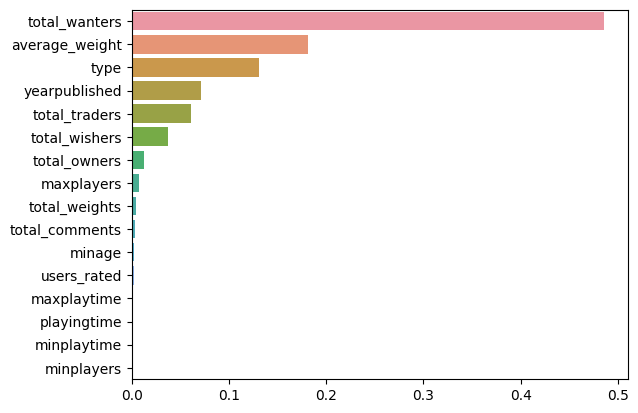

In [ ]:
feature_importances = DT_clean.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = DT_clean.feature_names_in_[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# bar plot of the feature importances
sns.barplot(x=sorted_importances, y=sorted_feature_names)

## Sub-model for Model 2: Dirty Data
- This submodel uses the "dirty" data set.
- We determine the **optimum hyperparameter for "max_depth" to be 8** via cross-validation, achieving an **accuracy of 37%** on our testing data.

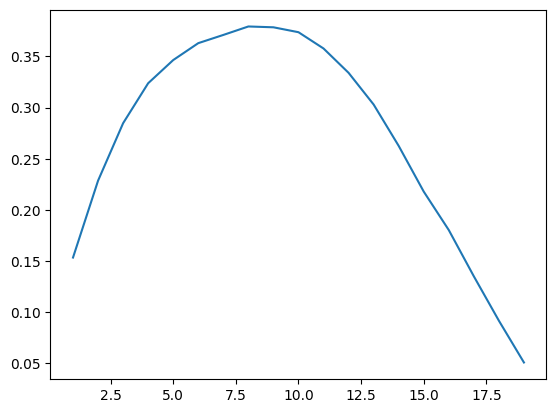

In [ ]:
sourceX = dirtyX
sourcey = dirtyy
accuracy = []
depths = [x for x in range(1,20)]

for depth in depths:
  DT_dirty = DecisionTreeRegressor(max_depth = depth, min_samples_leaf = 1)
  accuracy.append(cross_val_score(DT_dirty, sourceX, sourcey, cv = 5).mean())


plt.plot(depths,accuracy)

In [ ]:
DT_dirty = DecisionTreeRegressor(max_depth = 8)
DT_dirty.fit(dirtyX,dirtyy)
print(DT_dirty.score(dirtyTestX,dirtyTesty))

0.38630104551779254


### Feature importances
- Below we can see both visually and numerically the comparison between feature importances.  We found that:
 - "total_wishers" had a feature weight of .382
 - "yearpublished" had a feature weight of .221
 - "type" had a feature weight of .112
 - "average_weight" had a feature weight of .091
 - "bayes_average_rating" had a feature weight of .069

type 0.12015061310570381
yearpublished 0.24062927541909107
minplayers 0.004236612022512504
maxplayers 0.0034494855834705826
playingtime 0.008947244810919302
minplaytime 0.0013948782386587965
maxplaytime 0.0003599430741825867
minage 0.004142843094602574
users_rated 0.003439678703150811
total_owners 0.012850695320015242
total_traders 0.03315115431429014
total_wanters 0.027651965483767443
total_wishers 0.4097457396259422
total_comments 0.0026536698609066016
total_weights 0.0016661686490558108
average_weight 0.1255300326937305


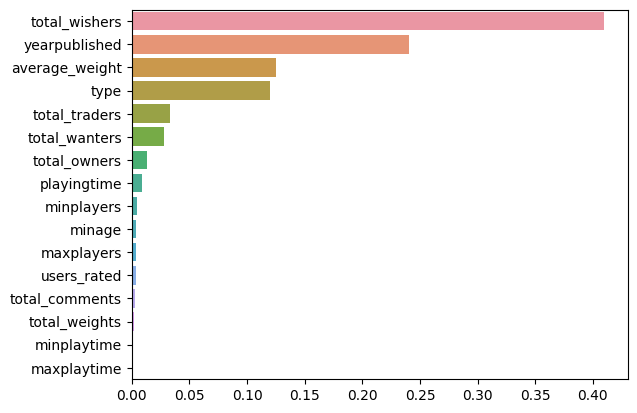

In [ ]:
feature_importances = DT_dirty.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = DT_dirty.feature_names_in_[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# bar plot of the feature importances
sns.barplot(x=sorted_importances, y=sorted_feature_names)
for i in range(len(DT_dirty.feature_names_in_)):
  print(DT_dirty.feature_names_in_[i],DT_dirty.feature_importances_[i])

## Sub-model for Model 2: Random Foresting
- For quick reference, our dirty data achieved a score of 42% and our clean data achieved a score of 73%

---
>> **NOTE:** We attempted to see if there were any better max_samples for our random foresting methodology.  Weirdly, despite the fact that theoretically *all* columns were being used, we still achieved a *lower* score than by not using max_samples at all.

In [ ]:
accDirty = []
accClean = []

for i in range(1, len(dirtyX.columns) +1):
  accDirty.append(cross_val_score(RandomForestRegressor(n_estimators = 100,max_samples = i,bootstrap = True, oob_score = True), dirtyX, dirtyy,cv = 5).mean())
  accClean.append(cross_val_score(RandomForestRegressor(n_estimators = 100,max_samples = i,bootstrap = True, oob_score = True), cleanX, cleany,cv = 5).mean())


fig = make_subplots(cols = 1)
fig.update_xaxes(title_text = "Max Samples: Trace 0 = dirtyData, Trace 1 = cleanData", col = 1 )
fig.add_trace(go.Scatter(x = [i for i in range(1, len(dirtyX.columns)+1)],
                     y = accDirty),
              row = 1,
              col = 1)
fig.add_trace(go.Scatter(x = [i for i in range(1, len(dirtyX.columns)+1 )],
                     y = accClean),
              row = 1,
              col = 1)


In [ ]:
RF_dirty = RandomForestRegressor(n_estimators = 100, bootstrap = True, oob_score = True)
RF_clean = RandomForestRegressor(n_estimators = 100, bootstrap = True, oob_score = True)

print("Dirty Random Forest Score: ", RF_dirty.fit(dirtyX,dirtyy).score(dirtyTestX,dirtyTesty))
print("Clean Random Forest Score: ", RF_clean.fit(cleanX,cleany).score(cleanTestX,cleanTesty))

Dirty Random Forest Score:  0.4131025344744037
Clean Random Forest Score:  0.7263904161524195


>> This seems to have lead to a roughly **7% increase in accuracy for our DIRTY data** and a **10% increase in accuracy for our CLEAN data**, compared to our Regression Tree models.  These results basically match the scores our cross validation suggested we might achieve.
---




In [ ]:
# @title Feature importances for Random Forest
fig = make_subplots(cols = 3,shared_yaxes= True)

fig.update_xaxes(title_text = "DirtyData Feature Importances",col = 1 )
fig.add_trace(go.Bar(x = RF_dirty.feature_names_in_[RF_dirty.feature_importances_.argsort()[::-1]],
                     y = RF_dirty.feature_importances_[RF_dirty.feature_importances_.argsort()[::-1]]),
              row = 1,
              col = 1)

fig.update_xaxes(title_text = "CleanData Feature Importances", col = 2 )
fig.add_trace(go.Bar(x = RF_clean.feature_names_in_[RF_clean.feature_importances_.argsort()[::-1]],
                     y = RF_clean.feature_importances_[RF_clean.feature_importances_.argsort()[::-1]]),
              row = 1 ,
              col = 2)

fig.update_xaxes(title_text = "Feature Comparisons, trace 2 = DirtyData, trace 3 = CleanData",col = 3)
fig.add_trace(go.Bar(x = RF_dirty.feature_names_in_,
                     y = RF_dirty.feature_importances_),
              row = 1,
              col = 3)
fig.add_trace(go.Bar(x = RF_clean.feature_names_in_,
                     y = RF_clean.feature_importances_),
              row = 1 ,
              col = 3)

fig.show()

# Model 3: SVR

- Using the Support Vector Regression model

Results:
 We executed 3 different kernels for SVR for both the dirty and clean data sets.
 - Polynomial regression took well over 10 minutes to complete whereas linear and RBF took 5 - 6 minutes each.
 - Polynomial also scored slightly lower than linear and much lower than RBF.
 - RBF had the best score out of all 3 kernels with around 0.33 accuracy for the dirty dataset and 0.66 accuracy for the clean dataset

 - For time and accuracy, we have kept in using the RBF and linear model. RBF had the best score for both datasets.

 - The execution of the code below took about 9 - 10 minutes

References:
- https://dataaspirant.com/svm-kernels/
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html


In [ ]:
# Polynomial takes too long and does not have the best score, sigmoid is not useful in this case
# orig_kernel = ['linear','rbf','poly','sigmoid']
kernel_models = ['linear','rbf']

for kernel in kernel_models:
  svr_games = SVR(kernel=kernel)
  svr_games.fit(dirtyX,dirtyy)
  print("Dirty Datset with Kernel ", kernel, " score: ", svr_games.score(dirtyX,dirtyy))

  svr_games.fit(cleanX,cleany)
  print("Clean Datset with Kernel ", kernel, " score: ", svr_games.score(cleanX,cleany))


Dirty Datset with Kernel  linear  score:  0.23067555220473945
Clean Datset with Kernel  linear  score:  0.469281912084174
Dirty Datset with Kernel  rbf  score:  0.32666071343692604
Clean Datset with Kernel  rbf  score:  0.6551540330750989
Elapsed time:  573.2989678382874


# Model 4: Ensembling Models

- Ensembling methods applied were bagging, voting, and random forest (separately earlier, as well as within bagging and voting)

- The basic approach for each method is to first declare the base learner models (estimators) LR, DT, and SVR. We also decided to include random foresting within the estimator group.

- For bagging: number of each base estimator is 10, and the estimators type is the same within each ensemble
- For voting: there are 3 base estimators for each ensemble that is either the same or a combination of the 4 estimators

In [7]:
from sklearn.ensemble import VotingRegressor  # majority voting for regression
from sklearn.ensemble import BaggingRegressor # bagging for regression

In [ ]:
# @title Bagging Regressor

Bnames = []
Bregressors = []

# using default of 10 estimator runs

Bregressors.append(BaggingRegressor( RFE(LinearRegression(),n_features_to_select = 5), n_estimators = 10)) # Linear Regression
Bnames.append("Bag(LRX3)")
Bregressors.append(BaggingRegressor( DecisionTreeRegressor(max_depth = 7), n_estimators = 10)) # Decision Trees
Bnames.append("Bag(DTX3)")
Bregressors.append(BaggingRegressor( RandomForestRegressor(bootstrap = True, oob_score = True), n_estimators = 10)) # Random Forest
Bnames.append("Bag(RFX3)")
Bregressors.append(BaggingRegressor( SVR(kernel='rbf'), n_estimators = 10)) # svr - rbf
Bnames.append("Bag(SVRX3)")


>>  **NOTES:**\
For dirty dataset, the following code takes 10-20 minutes to calculate.
- Dirty scores for Linear Regression were 22%.
- Dirty scores for Decision Trees were 40%.
- Dirty scores for Random Forests were 45%.
- Dirty scores for SVR were 33%.

>> For clean dataset, the following code takes 2 minutes to calculate.
- Clean scores for Linear Regression were 46%.
- Clean scores for Decision Trees were 67%.
- Clean scores for Random Forests were 71%.
- Clean scores for SVR were 64%.

>> Not surprisingly, **we saw a small increase in accuracy specifically from decision trees** for both clean and dirty models, since with bagging they act more like random forest models.  **For the other models, no noteable increase was produced.**

>> **ADDITIONAL NOTE:**  Our dirty dataset is commented out since bagging takes much longer to run than majority voting.


In [ ]:
for model, m_name in zip(Bregressors, Bnames):
    #model.fit(dirtyX, dirtyy)
    model.fit(cleanX, cleany)
    #print("\t", m_name, model.score(dirtyTestX, dirtyTesty) )
    print("\t", m_name, model.score(cleanTestX, cleanTesty) )

	 Bag(LRX3) 0.22372240234790974
	 Bag(DTX3) 0.4003460521224784
	 Bag(RFX3) 0.4483076381978507
	 Bag(SVRX3) 0.3348903824795487


In [8]:
# @title Voting Regressor
regressors = [ RFE(LinearRegression(), n_features_to_select = 5), SVR(kernel='rbf') , DecisionTreeRegressor(max_depth = 7), RandomForestRegressor(n_estimators = 100, bootstrap = True, oob_score = True)]
Vnames = []
ensembles = []

# Voting amongst all 3 base learner regressors
ensembles.append( VotingRegressor( [(type(x).__name__, x) for x in regressors] ) )
Vnames.append('Vote(LR,SVR,DT,RF)')
# for each base learner use 3 runs for each to compare to combination
ensembles.append( VotingRegressor([(x, RFE(LinearRegression(), n_features_to_select = 5) ) for x in ['LR1','LR2','LR3'] ]))
Vnames.append('Vote(LRx3)')
ensembles.append( VotingRegressor([(x, DecisionTreeRegressor(max_depth = 7) ) for x in ['DT1','DT2','DT3'] ]))
Vnames.append('Vote(SVRx3)')
ensembles.append( VotingRegressor([(x, SVR(kernel='rbf') ) for x in ['SVR1','SVR2','SVR3'] ]))
Vnames.append('Vote(DTx3)')

In [ ]:
## This block took 2 minutes to run, as usual with the majority of it being the dirty fitting/scoring.

RF_voting = VotingRegressor([(x, RandomForestRegressor(n_estimators = 100, bootstrap = True, oob_score = True) ) for x in ['RF1','RF2','RF3'] ])

RF_voting.fit(dirtyX, dirtyy)
print("\t", 'Dirty RFx3', RF_voting.score(dirtyTestX, dirtyTesty) )

RF_voting.fit(cleanX, cleany)
print("\t", 'Clean RFx3', RF_voting.score(cleanTestX, cleanTesty) )

	 Dirty RFx3 0.4338848040049883
	 Clean RFx3 0.7221411609763213


>>  **NOTE:** The following code cell first prints the scores for the dirty database and then the clean database for each of the ensemble models.
- All in all, there's not a lot of interesting things happening in these results.  Essentially, our LR and SVR results are identical to what we got previously. Our Decision Tree models once again saw a marginal increase in accuracy, again since the process of voting is similar in structure to Random Foresting.
- **Our strongest results came from the combination of all 4 models, as well as SVR**.  However, the **combination of 4 models ran significantly faster** than the SVR voting algorithm, indicating that the thing holding back SVR the most is its computation time.
- Additionally, **we are not seeing any improvement over purely random forest models**.

In [ ]:
## Takes 8+ minutes
print("Results for Dirty database")
for model, m_name in zip(ensembles, Vnames):
    model.fit(dirtyX, dirtyy)
    print("\t", m_name, model.score(dirtyTestX, dirtyTesty) )

## Takes 40 seconds
print("Results for Clean database")
for model, m_name in zip(ensembles, Vnames):
    model.fit(cleanX, cleany)
    print("\t", m_name, model.score(cleanTestX, cleanTesty) )

Results for Dirty database
	 Vote(LR,SVR,DT,RF) 0.40212807799630357
	 Vote(LRx3) 0.2188738630341711
	 Vote(SVRx3) 0.3816018432337699
	 Vote(DTx3) 0.33492491299480676
Results for Clean database
	 Vote(LR,SVR,DT,RF) 0.6737524303089599
	 Vote(LRx3) 0.4645526280250678
	 Vote(SVRx3) 0.6153045399962302
	 Vote(DTx3) 0.6428063738764003


>>  **NOTE:** Below is a plot thats shows 30 predictions for the base regressor models LR, SVR, DT, and RF (without applying voting regressor). Pred5 is the prediction for Vote(LR,SVR,DT,RF) ensemble.
- source for plotting: https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py

>> **The intention of the plot is to show how the Vote(LR,SVR,DT,RF) line generates its scoring by combining via averaging the results for the other methods, as well.**

In [9]:
## This block recreates each of our models, so it takes roughly 5 minutes to run

pred1 = regressors[0].fit(dirtyX, dirtyy).predict(dirtyTestX[:30]) # LR
pred2 = regressors[1].fit(dirtyX, dirtyy).predict(dirtyTestX[:30]) # SVR
pred3 = regressors[2].fit(dirtyX, dirtyy).predict(dirtyTestX[:30]) # DT
pred4 = regressors[3].fit(dirtyX, dirtyy).predict(dirtyTestX[:30]) # RF
pred5 = ensembles[0].fit(dirtyX, dirtyy).predict(dirtyTestX[:30]) # Vote(LR,SVR,DT,RF)

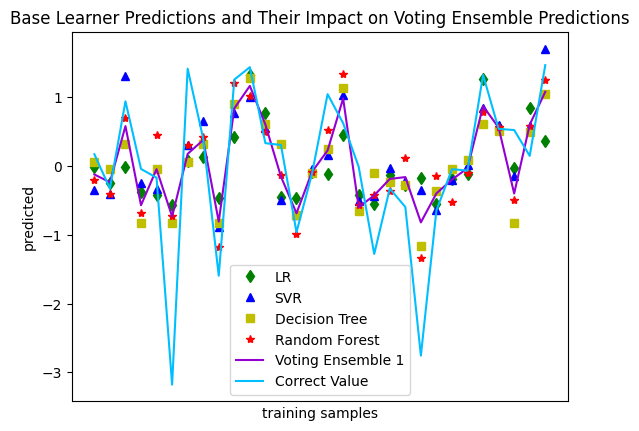

In [16]:
plt.figure()
plt.plot(pred1, "gd", label="LR")
plt.plot(pred2, "b^", label="SVR")
plt.plot(pred3, "ys", label="Decision Tree")
plt.plot(pred4, "r*", label="Random Forest")
plt.plot(pred5, "darkviolet", label="Voting Ensemble 1")
plt.plot([x for x in dirtyTesty[:30]], 'deepskyblue', label="Correct Value")


plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Base Learner Predictions and Their Impact on Voting Ensemble Predictions")

plt.show()

# Summary and Conclusion

The maximum achieved accuracy with purely the data original given to us was 45%, achieved using Random Foresting.  The next closest model was that of RBF-based Support Vector Regression, with an accuracy of 33%.  While still atrociously bad, this is still better than purely linear regression, which achieved only around 22% accuracy on its best trials.  

However, as the saying goes: "Garbage in; garbage out."  We fully expected that without cleaning up our data, we would struggle to find a truly successful model.  To counter this, we ran our models using heavily cleaned data as well, and they showed strong improvement.  Our Random Foresting scores jumped to 72%, and our RBF SVM scores jumped to 65%.

We could have boosted those numbers further with the inclusion of "bayes_average_rating" in our clean data, which would increase our Random Foresting scores to at least 96%, our SVR scores to 85%, and even our Linear Regression scores to 60%.  In fact, it could have knocked out the necessity for Random Foresting at all, since a pure 10-depth decision tree was also able to achieve 92% accuracy.  However, we felt like this would be using the answer to predict itself, and thus would provide no truly useful information. We are instead satified saying that 72% accurate is the best we can do with this dataset.